In [4]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="#">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Imports

In [ ]:
import os
import time
import math
from itertools import combinations
from tqdm import tqdm
import shutil
import zipfile
import pandas as pd
import numpy as np
import pandas as pd
import random
from PIL import Image
from skimage.io import imshow, imread

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision
from sklearn.preprocessing import StandardScaler
import joblib

import matplotlib.pyplot as plt
import cv2


from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor


In [ ]:
def set_torch_seed(seed: int = 42):
    """
    Define uma semente global para garantir reprodutibilidade em PyTorch, NumPy e random.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # para múltiplas GPUs

    # Garante comportamento determinístico (pode impactar performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Semente definida: {seed}")
set_torch_seed(2025)

# Utilitários

In [ ]:

def list_image_files(root_dir, extensions={'.jpg', '.jpeg', '.png', '.bmp'}): # utils junior novo
    """
    Lista todas as imagens recursivamente.
    Args:
      - root_dir: image root directory
      - extensions: the extension
    """
    image_paths = []
    for dirpath, _, filenames in os.walk(root_dir):
        for fname in filenames:
            if os.path.splitext(fname)[1].lower() in extensions:
                image_paths.append(os.path.join(dirpath, fname))
    return image_paths


def criar_scaler_para_split(dataframe, dir_arquivo_saida):
  """
  Criar um scaler baseado em Z-Score normalization a partir dos feature vector reais
  associados com cada ID de amostra. O scaler é uma funçao que permite inversão para 
  permitir a volta para o valor original

  Z-Score Nomralization: um tipo de padronização que substrai a média e divide pelo desvio padrão.

  args:
    dataframe: datataframe originado de medidas_dados_sinteticos.csv e associado com um split
    nome_arquivo_saida: nome do arquivo no formato .pkl que contém objeto StandarScaler do sklearn.

  """
  if ".pkl" not in dir_arquivo_saida:
    raise ValueError("Nome do arquivo deve conter a extensão .pkl")

  # Define colunas de rótulo
  exclude_cols = ['id', 'height', 'split']
  label_cols = [col for col in dataframe.columns if col not in exclude_cols]

  # Extrai rótulos como matriz
  labels_original = dataframe[label_cols].values.astype('float32')

  # Fit e transformação
  scaler = StandardScaler()
  scaler = scaler.fit(labels_original)

  # Salva o scaler para uso na inferência
  joblib.dump(scaler, dir_arquivo_saida)


def salvar_silhuetas(img, mask, output_folder, nome_imagem):
  """
  Salva a máscara binária e a imagem com contornos da silhueta em arquivos PNG.

  Esta função realiza os seguintes passos:
  1. Salva a máscara binária da silhueta.
  2. Detecta contornos na máscara limpa.
  3. Desenha os contornos sobre a imagem original.
  4. Salva a imagem com os contornos desenhados.

  Args:
  ----------
  img : torch.Tensor
      Tensor da imagem original com formato (1, C, H, W), normalizada entre 0 e 1.

  mask : numpy.ndarray
      Máscara binária da silhueta com valores entre 0 e 1.

  output_folder : str
      Caminho da pasta onde os arquivos serão salvos. A pasta será criada se não existir.

  nome_imagem : str
      Nome base para os arquivos gerados (sem extensão). Será usado para nomear os arquivos
      de saída como "<nome_imagem>_mask.png" e "<nome_imagem>_boundary.png".

  Returns:
  -------
  None
      Os arquivos são salvos diretamente no sistema de arquivos. A função não retorna valores.
  """
  # Garantir que a pasta de saída existe
  os.makedirs(output_folder, exist_ok=True)
  # Salvar a máscara binária
  mask_path = os.path.join(output_folder, f"{nome_imagem}_mask.png")
  cv2.imwrite(mask_path, mask * 255)
  # Preparar imagem original
  img_arr = img.cpu().squeeze().permute((1, 2, 0)).detach().numpy().copy()
  img_arr = (img_arr * 255).astype(np.uint8)
  
  #mask_clean = (mask > 0.5).astype(np.uint8) * 255
  #mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
  #mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
  mask = (mask > 0.5).astype(np.uint8) * 255
  # Encontrar contornos
  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  # Desenhar contornos sobre a imagem original
  overlay = img_arr.copy()
  cv2.drawContours(overlay, contours, -1, (0, 0, 255), thickness=2)
  # Salvar imagem com contornos
  boundary_path = os.path.join(output_folder, f"{nome_imagem}_boundary.png")
  cv2.imwrite(boundary_path, overlay)


# Análise Exploratória e Preparação dos dados

In [ ]:
diretorio_pasta_dados_drive = '/content/drive/MyDrive/Colab Notebooks/SelecaoINOVAI/datasets'

# List files
os.listdir(diretorio_pasta_dados_drive)


In [ ]:
# copia arquivo CSV do drive para o colab
shutil.copy(diretorio_pasta_dados_drive + '/medidas_dados_sinteticos.csv', '/content/medidas_dados_sinteticos.csv')


O dataset contém imagens frontais e lateriais do corpo.
- cada pasta dentro do dos arquivos zip possuem nomes que indicam o ID da amostra
- Cada ID contém uma imagem frontal e outra lateral.
- 'syn_m' na subpasta indica masculino
- 'sys_f' na subpasta indica feminino
- Cada ID da imagem possui informações de medidas do corpo no arquivo medidas_dados_sinteticos.csv

In [ ]:
## Unzip as pastas  'homens_15k.zip' e 'mulheres_15k.zip' onde as imagens estão contidas

# Pasta de destino para salvar no colab [ALTERE AQUI se necessário], e será removido se desligar o ambiente
destination_path = '/content/unzipped_files'

zip_file_paths = [
    diretorio_pasta_dados_drive + '/mulheres_15k.zip',
    diretorio_pasta_dados_drive + '/homens_15k.zip'
]

os.makedirs(destination_path, exist_ok=True)

# Unzip
for zip_file_path in zip_file_paths:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(destination_path)

In [2]:
## vamos observar o arquivos CSV de medidas corporais
df_medidas = pd.read_csv("/content/medidas_dados_sinteticos.csv")
print(df_medidas.shape)
df_medidas.tail()


NameError: name 'pd' is not defined

In [ ]:
# renomeando algumas colunas para pt-br
df_medidas.rename(columns={
    'neck_circ': 'pescoco_circ',
    'chest_circ': 'peito_circ',
    'waist_circ': 'cintura_circ',
    'hip_circ': 'quadril_circ',
    'thigh_circ': 'coxa_circ',
    'knee_circ': 'joelho_circ',
    'calf_circ': 'panturrilha_circ',
    'abd_circ': 'abdomen_circ',
    'biceps_circ': 'biceps_circ'
}, inplace=True)

df_medidas.head()

In [ ]:
## comparando o total de linhas no arquivo CSV com o total de imagens

if len(os.listdir(destination_path)) * 2 != df_medidas.shape[0]:
   print("numero de linha não é igual ao total de imagens extraídas")

Conforme observado na célula anterior, algumas imagens reportadas no CSV não estão contidas no pasta que extraimos com aquivos .pngs da próprias imagens. Então, vamos filtrar o Dataframe 'df_medidas' para manter apenas os IDs presentes nos arquivos de imagens.

In [ ]:
## Filtrando df_medidas para manter apenas os IDs presentes nos arquivos de imagens

# Obter ids das imagens
ids_normes_arquivos = os.listdir(destination_path)
# Obter somente medidas de amostras que estão associadas com imagens
df_medidas_filtrado = df_medidas[df_medidas['id'].isin(ids_normes_arquivos)].reset_index(drop=True)

print("Antes: ", df_medidas.shape[0])
print("Depois: ", df_medidas_filtrado.shape[0])

In [ ]:
df_medidas_filtrado.head()

## Divisão em treino, validação e teste 

In [ ]:
## Verificando contagem de amostras por tipo de split (train, validation, test, unknown)

df_medidas_filtrado['split'].value_counts()


In [ ]:
## Agora vou particionar o Dataframe por tipo de split. Note que unknown será considerado teste.

df_medidas_filtrado_treino = df_medidas_filtrado[df_medidas_filtrado['split'] == 'train'].reset_index(drop=True)
treino_ids = df_medidas_filtrado_treino.id.tolist()

df_medidas_filtrado_val = df_medidas_filtrado[df_medidas_filtrado['split'] == 'val'].reset_index(drop=True)
val_ids = df_medidas_filtrado_val.id.tolist()


df_medidas_filtrado_teste = df_medidas_filtrado[df_medidas_filtrado['split'].isin(['test', 'unknown'])].reset_index(drop=True)
teste_ids = df_medidas_filtrado_teste.id.tolist()



In [ ]:
df_medidas_filtrado_treino.head(1)

Como o dataframe originado do arquivo CSV somente possui informações associadas com um ID único para cada amostra e sabendo que cada amostra possui duas imagens para a parte frontal e lateral do corpo, então vou obter o caminho completo de cada imagem associada com o ID por tipo de split.

In [ ]:
diretorios_imagens = list_image_files(destination_path)

## Filtrando os caminhos cujas subpastas estão em train_ids
treino_diretorios_imagens = [
    path for path in diretorios_imagens
    if os.path.basename(os.path.dirname(path)) in treino_ids
]
## Filtrando os caminhos cujas subpastas estão em val_ids
validacao_diretorios_imagens = [
    path for path in diretorios_imagens
    if os.path.basename(os.path.dirname(path)) in val_ids
]

## Filtrando os caminhos cujas subpastas estão em teste_ids
teste_diretorios_imagens = [
    path for path in diretorios_imagens
    if os.path.basename(os.path.dirname(path)) in teste_ids
]

print("Total de imagens para treino: ", len(treino_diretorios_imagens))
print("Total de imagens para validação: ", len(validacao_diretorios_imagens))
print("Total de imagens para teste: ", len(teste_diretorios_imagens))

Observe que o toal de imagens por split é justamente o dobro de amostras no dataframe associado com aquele split

Agora que possuimos os caminho completos das imagens e informações associadas com imagem, então podemos prosseguir com a criação do Dataset Pytorch.

## Criando Dataset Pytorch

In [ ]:
## Criação de um scaler para efetura Z-Score Normalization para cada split. Essa normalização vai
# ser útil para padronizar os vetores de características multivaridos que devemos estimar por
# regressão. É uma estretégia conhecida de Séries Temporaris. 
# A motivação é que Funções de Perda comuns, como MSE (Erro Quadrático Médio), são sensíveis à magnitude. Valores maiores dominam a perda, 
# mesmo que sejam menos significativos.


criar_scaler_para_split(
    dataframe=df_medidas_filtrado_treino,
    dir_arquivo_saida="treino_scaler.pkl"
)


criar_scaler_para_split(
    dataframe=df_medidas_filtrado_val,
    dir_arquivo_saida="validacao_scaler.pkl"
)


criar_scaler_para_split(
    dataframe=df_medidas_filtrado_teste,
    dir_arquivo_saida="teste_scaler.pkl"
)


In [ ]:



class U2NetToTensor(object):
    """
    Versão levemente modificada de
    https://github.com/xuebinqin/U-2-Net/blob/ac7e1c817ecab7c7dff5ce6b1abba61cd213ff29/data_loader.py#L103

    Converte uma imagem ndarray para tensor.
    Esta versão ignora 'label' e 'imidx', retornando apenas a imagem normalizada como tensor.
    """

    def __call__(self, image):
        # Normaliza a imagem para [0, 1]
        image = image / np.max(image)

        # Inicializa imagem com 3 canais
        tmpImg = np.zeros((image.shape[0], image.shape[1], 3))

        # Aplica normalização tipo ImageNet
        if image.shape[2] == 1:
            tmpImg[:, :, 0] = (image[:, :, 0] - 0.485) / 0.229
            tmpImg[:, :, 1] = (image[:, :, 0] - 0.485) / 0.229
            tmpImg[:, :, 2] = (image[:, :, 0] - 0.485) / 0.229
        else:
            tmpImg[:, :, 0] = (image[:, :, 0] - 0.485) / 0.229
            tmpImg[:, :, 1] = (image[:, :, 1] - 0.456) / 0.224
            tmpImg[:, :, 2] = (image[:, :, 2] - 0.406) / 0.225

        # Transforma para formato [C, H, W]
        tmpImg = tmpImg.transpose((2, 0, 1))

        # Retorna apenas o tensor da imagem
        return torch.from_numpy(tmpImg).float()


class RegressaoDataset(Dataset):
    """
    Dataset para nossa tarefa de regressão

    Este dataset associa imagens a vetores de rótulos numéricos extraídos dos DataFrames dos splits originado do aqruivo de medidas.
    Os rótulos podem ser opcionalmente normalizados com um objeto scaler (ex: StandardScaler).

    As imagens são transformadas com redimensionamento, conversão para tensor e normalizadas no intervalo 0,1.

    Parameters
    ----------
    image_paths : list of str
        Lista de caminhos absolutos para os arquivos de imagem.
    dataframe : pandas.DataFrame
        DataFrame contendo os rótulos associados a cada imagem. Deve conter uma coluna 'id'
        que corresponde ao nome da pasta onde a imagem está localizada.
    scaler : object
        Objeto de normalização (ex: StandardScaler) com método `.transform()` para aplicar nos rótulos.
    aplicar_rotulo_scaler : bool, optional
        Se True, aplica o scaler aos rótulos. Caso contrário, os rótulos são mantidos em seu formato original.
        Default é False.
    exclude_cols : list of str, optional
        Lista de colunas a serem excluídas do conjunto de rótulos. Default é ['id', 'height', 'split'].
    u2net : bool, optional
        Se True, aplica o preprocessamento da U2Net. Caso contrário, o prepocessamento com ToTensor é aplicado para normalizar a imagem converter 
        de PIL para Tensor com valores intervalo [0,1]. [Atenção]: esse argumento deve ser True se você está usando U2Net durante o treinamento
        ou inferência.
    """

    def __init__(self, image_paths, dataframe, scaler, aplicar_rotulo_scaler=False, exclude_cols=['id', 'height', 'split'], u2net=False):
        self.image_paths = image_paths
        self.df = dataframe

        if unet != True
            self.transform = T.Compose([
                T.Resize((512, 512)),
                T.ToTensor(), # normaliza [0,1]
               # T.Normalize(mean=[0.485, 0.456, 0.406],
               #             std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = T.Compose([
                T.Resize((512, 512)),
                U2NetToTensor(), # normaliza [0,1]
            ])
            
    
        self.label_cols = [col for col in self.df.columns if col not in exclude_cols]

        if aplicar_rotulo_scaler:
            self.id_to_label = {
                row['id']: scaler.transform(row[self.label_cols].values.astype('float32').reshape(1, -1))
                for _, row in self.df.iterrows()
            }
        else:
            self.id_to_label = {
                row['id']: row[self.label_cols].values.astype('float32').reshape(1, -1)
                for _, row in self.df.iterrows()
            }

    def __len__(self):
        """
        Retorna o número total de amostras no dataset.

        Returns
        -------
        int
            Número de imagens no dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Recupera a imagem e o vetor de rótulos correspondente ao índice fornecido.

        Parameters
        ----------
        idx : int
            Índice da amostra desejada.

        Returns
        -------
        image : torch.Tensor
            Imagem transformada como tensor normalizado.
        label : torch.Tensor
            Vetor de rótulos associado à imagem, convertido para tensor float32.

        Raises
        ------
        ValueError
            Se o ID da imagem não for encontrado no mapeamento de rótulos.
        """
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        folder_id = os.path.basename(os.path.dirname(img_path))
        label = self.id_to_label.get(folder_id)

        if label is None:
            raise ValueError(f"ID '{folder_id}' não encontrado no split.")

        return image, torch.tensor(label, dtype=torch.float32)


Observe abaixo que apliquei o scaler somente no treino, pois a validação é uma simulação do teste. O scaler possui  método 'inverse_transform' responsável por transformar as valores padronizados para o espaço dos valores reais das medidas.

In [ ]:

treino_scaler = joblib.load("/content/treino_scaler.pkl")
val_scaler = joblib.load("/content/validacao_scaler.pkl")
teste_scaler = joblib.load("/content/teste_scaler.pkl")

treino_dataset = RegressaoDataset(
    image_paths = treino_diretorios_imagens,
    scaler = treino_scaler,
    aplicar_rotulo_scaler=True,
    dataframe = df_medidas_filtrado_treino,
    u2net=True,
)



val_dataset = RegressaoDataset(
    image_paths = validacao_diretorios_imagens,
    scaler = val_scaler,
    aplicar_rotulo_scaler=False,
    dataframe = df_medidas_filtrado_val,
    u2net=True,
)



teste_dataset = RegressaoDataset(
    image_paths = teste_diretorios_imagens,
    scaler = teste_scaler,
    aplicar_rotulo_scaler=False,
    dataframe = df_medidas_filtrado_teste,
    u2net=True,
)



# Modelagem 

In [13]:
class SegmentationModule:
    """
    Segmentação semântica da pessoa na imagem.
    - Usa modelo DeepLabV3 pré-treinado do torchvision.
    - Retorna a máscara binária da pessoa (silhueta) e a imagem original.
    """

    def __init__(self):
        # Carrega modelo DeepLabV3 com backbone ResNet50, pré-treinado no COCO
        self.model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
        self.model.eval()  # modo avaliação, desativa dropout etc.

        # Pré-processamento: redimensionar para 512x512 e converter para tensor
        self.preprocess = transforms.Compose([
            T.Resize((512, 512)),
            T.ToTensor(),
        ])
    
    def extract_silhouette(self, image_path):
        # Abrir imagem com PIL e converter para RGB
        img = Image.open(image_path).convert("RGB")

        # Pré-processar e adicionar dimensão batch (1, C, H, W)
        input_tensor = self.preprocess(img).unsqueeze(0)

        # Forward pass do modelo para segmentação
        with torch.no_grad():
            output = self.model(input_tensor)['out'][0]  # saída do modelo

        # COCO class 15 = pessoa
        mask = (output.argmax(0) == 15).byte().cpu().numpy()  # 1=pessoa, 0=fundo
        mask_img = mask * 255  # escala para 0-255 para visualização

        # Mostrar imagem original e silhueta lado a lado
        fig, axs = plt.subplots(1,2, figsize=(8,4))
        axs[0].imshow(img)
        axs[0].set_title("Imagem Original")
        axs[1].imshow(mask_img, cmap="gray")
        axs[1].set_title("Silhueta Extraída")
        for ax in axs: ax.axis("off")
        plt.show()

        # Retorna máscara binária e imagem original como array numpy
        return mask_img, np.array(img)

In [ ]:
class DeepLabSegmentationModule:
    """
    Segmentação semântica da pessoa na imagem.
    - Usa modelo DeepLabV3 pré-treinado do torchvision.
    - Retorna a máscara binária da pessoa (silhueta).
    """

    def __init__(self, device):
        # Carrega modelo DeepLabV3 com backbone ResNet50, pré-treinado no COCO
        self.model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True).to(device)
        self.model = self.model.eval()  # modo avaliação, desativa dropout etc.

    def visualizar_silhueta(self, mask_img):
        # Mostrar imagem original e silhueta lado a lado
        mask_img = mask * 255  # escala para 0-255 para visualização
        fig, axs = plt.subplots(1,2, figsize=(8,4))
        axs[0].imshow(img.cpu().squeeze().permute((1,2,0)).detach().numpy())
        axs[0].set_title("Imagem Original")
        axs[1].imshow(mask_img, cmap="gray")
        axs[1].set_title("Silhueta Extraída")
        for ax in axs: ax.axis("off")
        plt.show()

    def extract_silhouette(self, input_tensor):
        # Forward pass do modelo para segmentação
        with torch.no_grad():
            output = self.model(input_tensor)['out'][0]  # saída do modelo

        # COCO class 15 = pessoa
        mask = (output.argmax(0) == 15).byte().detach().cpu().numpy()  # 1=pessoa, 0=fundo

        # Retorna máscara binária 
        return mask
        

In [14]:
class KeypointsModule:
    """
    Detecta pontos-chave aproximados da silhueta da pessoa.
    Abordagem simplificada sem usar MediaPipe:
    - Usa o contorno da silhueta para localizar o corpo.
    - Calcula uma bounding box (retângulo) ao redor do contorno.
    - Estima keypoints com base em proporções dentro da bounding box.
    """

    def extract_keypoints(self, mask):
        # Encontrar todos os contornos na máscara
        # cv2.RETR_EXTERNAL -> pega apenas os contornos externos
        # cv2.CHAIN_APPROX_SIMPLE -> reduz número de pontos do contorno
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 0:
            # Nenhum contorno encontrado → retorna dicionário vazio
            return {}

        # Seleciona o maior contorno, que corresponde à pessoa
        c = max(contours, key=cv2.contourArea)

        # Calcula a bounding box do contorno
        # x, y -> canto superior esquerdo da caixa
        # w, h -> largura e altura da caixa
        x, y, w, h = cv2.boundingRect(c)

        # Estima keypoints com base em proporções da bounding box
        keypoints = {
            'top_head': (x + w//2, y),                # topo da cabeça
            'neck': (x + w//2, y + h//10),           # pescoço (10% da altura)
            'shoulders': (x + w//2, y + h//5),       # ombros (20% da altura)
            'waist': (x + w//2, y + h//2),           # cintura (50% da altura)
            'hips': (x + w//2, y + int(h*0.6)),      # quadril (60% da altura)
            'knees': (x + w//2, y + int(h*0.8)),     # joelhos (80% da altura)
            'ankles': (x + w//2, y + h),             # tornozelos (base da bounding box)
        }

        # Retorna dicionário com keypoints aproximados
        return keypoints

In [15]:
import numpy as np

class RegressionModule:
    """
    Converte keypoints em medidas corporais aproximadas.
    Para protótipo, gera valores simulados baseados em proporções.
    """
    def predict_measures(self, keypoints):
        measures = {}
        if not keypoints:
            return measures

        # Exemplo: usar distância entre pontos como proxy
        def distance(p1, p2):
            return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

        measures['pescoço'] = distance(keypoints['top_head'], keypoints['neck']) * 1.2
        measures['peito'] = distance(keypoints['shoulders'], keypoints['waist']) * 2
        measures['cintura'] = distance(keypoints['waist'], keypoints['hips']) * 1.5
        measures['quadril'] = distance(keypoints['hips'], keypoints['knees']) * 1.3
        measures['coxa'] = distance(keypoints['hips'], keypoints['knees'])
        measures['joelho'] = distance(keypoints['knees'], keypoints['ankles'])
        measures['panturrilha'] = distance(keypoints['knees'], keypoints['ankles']) * 0.7
        measures['abdomen'] = measures['cintura'] * 0.9
        measures['biceps'] = measures['peito'] * 0.3

        return measures

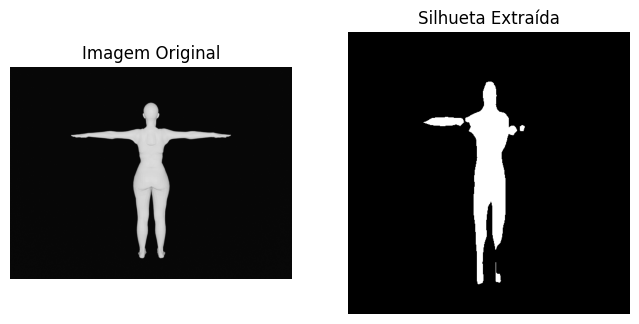

Medidas estimadas (aproximadas):
pescoço: 43.20 px
peito: 222.00 px
cintura: 54.00 px
quadril: 96.20 px
coxa: 74.00 px
joelho: 74.00 px
panturrilha: 51.80 px
abdomen: 48.60 px
biceps: 66.60 px


In [17]:
# main_pipeline.py
seg_module = SegmentationModule()
kp_module = KeypointsModule()
reg_module = RegressionModule()

mask, image = seg_module.extract_silhouette("female-001289_B00.png")
keypoints = kp_module.extract_keypoints(mask)
measures = reg_module.predict_measures(keypoints)

print("Medidas estimadas (aproximadas):")
for k,v in measures.items():
    print(f"{k}: {v:.2f} px")

## Modelagem U2Net


Nesta seção, mostramos a implementação do código de inferência da U2Net.

O código da arquitetura da U2Net foi copiado da implementação original dos autores, disponível em: [https://github.com/xuebinqin/U-2-Net](https://github.com/xuebinqin/U-2-Net). Utilizamos essa arquitetura para carregar o modelo de segmentação de pessoas, cujo *checkpoint* pode ser baixado neste link: [https://drive.google.com/file/d/1m_Kgs91b21gayc2XLW0ou8yugAIadWVP/view?usp=sharing](https://drive.google.com/file/d/1m_Kgs91b21gayc2XLW0ou8yugAIadWVP/view?usp=sharing). Esse *checkpoint* é fornecido no repositório oficial da U2Net no GitHub.

- Criamos um módulo PyTorch chamado `U2NetSegmentationModule`, que carrega os parâmetros do arquivo `u2net_human_seg.pth` na arquitetura da U2Net. Para facilitar a abstração do sistema, o `U2NetSegmentationModule` foi desenvolvido com uma interface de métodos compatível com os módulos `SegmentationModule` e `DeepLabSegmentationModule`, permitindo redução de alterações majoritárias no código de inferência.

- Note que, ao criar o `RegressaoDataset`, é necessário definir o argumento `u2net` do construtor da classe como `True` antes de realizar inferência ou treinamento com esse modelo.


In [ ]:
#@title U2Net

# código copiado de https://github.com/xuebinqin/U-2-Net/blob/master/model/u2net.py
class REBNCONV(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dirate=1):
        super(REBNCONV,self).__init__()

        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self,x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout

## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src,tar):

    src = F.interpolate(src,size=tar.shape[2:],mode='bilinear') # to avoid depreciated
    #F.upsample(src,size=tar.shape[2:],mode='bilinear')

    return src


### RSU-7 ###
class RSU7(nn.Module):#UNet07DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d =  self.rebnconv6d(torch.cat((hx7,hx6),1))
        hx6dup = _upsample_like(hx6d,hx5)

        hx5d =  self.rebnconv5d(torch.cat((hx6dup,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-6 ###
class RSU6(nn.Module):#UNet06DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)


        hx5d =  self.rebnconv5d(torch.cat((hx6,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-5 ###
class RSU5(nn.Module):#UNet05DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4 ###
class RSU4(nn.Module):#UNet04DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4F ###
class RSU4F(nn.Module):#UNet04FRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx2d = self.rebnconv2d(torch.cat((hx3d,hx2),1))
        hx1d = self.rebnconv1d(torch.cat((hx2d,hx1),1))

        return hx1d + hxin


##### U^2-Net ####
class U2NET(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NET,self).__init__()

        self.stage1 = RSU7(in_ch,32,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,32,128)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(128,64,256)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(256,128,512)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(512,256,512)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(512,256,512)

        # decoder
        self.stage5d = RSU4F(1024,256,512)
        self.stage4d = RSU4(1024,128,256)
        self.stage3d = RSU5(512,64,128)
        self.stage2d = RSU6(256,32,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(128,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(256,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(512,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(512,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #-------------------- decoder --------------------
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return F.sigmoid(d0), F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)

In [ ]:
class U2NetSegmentationModule:
    """
        Detecção de Objeto Saliente pessoa na imagem.
        - Usa modelo U2Net pré-treinado para segmentar pessoas.
        - Retorna a máscara binária da pessoa (silhueta) após limiarização da saída da U2Net.
    """

    def __init__(self, model_dir):
        """
        model_dir: diretório do modelo U2Net
        """
        # Carrega modelo U2Net pretreinada
        self.model = U2NET(3,1)

        if torch.cuda.is_available():
          self.model.load_state_dict(torch.load(model_dir))
          self.model.to("cuda")
        else:
          self.model.load_state_dict(torch.load(model_dir, map_location='cpu'))

        self.model = self.model.eval()  # modo avaliação

    def normPRED(d):
      # função copiada de https://github.com/xuebinqin/U-2-Net/tree/master
      """
      Realiza normalização MIN-MAX na entrada.
      Args:
        - d: Mapa de Saliência de entrada. Numpy array de tamanho HxWxC
      """
      ma = torch.max(d)
      mi = torch.min(d)

      dn = (d-mi)/(ma-mi)

      return dn

    def otsu_binarization(inp):
      """
        Realiza a binarização adaptativa de OTSU em uma imagem de entrada

        Args:
          - inp: Mapa de Saliência de entrada. Numpy array de tamanho HxWxC

        Return:
          - mask: Máscara binária. Numpy array of shape HxWx1
      """

      # limiarização adaptativa com OTSU
      otsu_thresh = threshold_otsu(inp)
      mask = (inp > otsu_thresh).astype(np.uint8) # 1: objeto, 0: fundo
      return mask



    def visualizar_silhueta(self, img, mask):
        # Mostrar imagem original e silhueta lado a lado
        mask_img = mask * 255  # escala para 0-255 para visualização
        fig, axs = plt.subplots(1,2, figsize=(8,4))
        axs[0].imshow(img.cpu().squeeze().permute((1,2,0)).detach().numpy())
        axs[0].set_title("Imagem Original")
        axs[1].imshow(mask_img, cmap="gray")
        axs[1].set_title("Silhueta Extraída")
        for ax in axs: ax.axis("off")
        plt.show()

    def extract_silhouette(self, input_tensor):
        # Forward pass do modelo para segmentação
        with torch.no_grad():
             saliencia,_,_,_,_,_,_ =  self.model(input_tensor)  # saída do modelo

        # convertendo saliencia do intervalo [0,1] para máscara binária
        pred = saliencia[:,0,:,:]
        pred = U2NetSegmentationModule.normPRED(pred)

        pred = pred.squeeze()
        pred = pred.cpu().data.numpy()

        # limiarização adaptativa com OTSU
        mask = U2NetSegmentationModule.otsu_binarization(pred) # 1: objeto, 0: fundo

        return mask


## Modelagem e Treinamento do XGBoost

### Preparação dos dados para treinar o XGBoost

In [ ]:

# Criação do DataLoader
treino_loader = DataLoader(
    dataset=treino_dataset,
    batch_size=1,
    shuffle=False,
    #pin_memory=True,
    #num_workers=2
)


Considerando que devemos extrair informações de pontos chaves, então criamos o módulo reponsável por extrair
um vetor de características onde cada componente deste vetor corresponde à norma euclidiana (distância) entre N corrdenadas 2D de pontos chaves detectados da silhueta, porém devido a simetria da distância euclidiana e para evitar redundância de valores, usamos apenas pares de pontos únicos sem repetição.

In [ ]:

class ExtractFeaturesKeypoints(nn.Module):
    """
    Extrai um vetor de características com as distâncias euclidianas entre pares únicos de keypoints.

    Para N keypoints, o vetor de saída terá N(N-1)/2 valores, correspondentes às distâncias entre
    todos os pares distintos (sem repetição e sem pares consigo mesmo).

    Parâmetros:
        keypoints (dict): Dicionário com keypoints nomeados. Exemplo:
            {
                'top_head': (x1, y1),
                'neck': (x2, y2),
                ...
            }

    Retorno:
        torch.Tensor: Vetor 1D com shape (N(N-1)/2), contendo as distâncias euclidianas entre pares únicos.
    """
    def __init__(self):
        super(ExtractFeaturesKeypointsV2, self).__init__()

    def forward(self, keypoints: dict):
        coords = torch.tensor(list(keypoints.values()), dtype=torch.float32)  # shape: [N, 2]
        pairs = list(combinations(range(len(coords)), 2))  # isso gera pares únicos de indices da lista coords (keypoint)

        distances = []
        for i, j in pairs:
            dist = torch.norm(coords[i] - coords[j])
            distances.append(dist)

        return torch.stack(distances)  # total: [N(N-1)/2]


A função `generate_regressor_data` a seguir vai gerar e salvar os tensores que armazenam as features extraídas do pontos chaves
e os vetores de medidas alvos que devemos estimar. Em suma, armazenamos um tensor de vetores de caractéricas extraídas dos pontos chanve com tamanho `Bx21` onde B é o toal de amostras e 21 é o toal de distâncias computadas no módulo `ExtractFeaturesKeypoints`, enquanto outro tensor possui o tamanho `Bx9` para as nove medidas corporais que devemos regredir. Um modelo de Regressão Múltipla de Aprendizado de Máquina ou Aprendizado Profundo deve aprender uma função não linear que vai converter o vetor  `Bx21` para o vetor `Bx9`.

In [ ]:
@torch.no_grad()
def generate_regressor_data(save_tensors=False):
  features_list = []
  labels_list = []
  # 30 minutos
  for img, label in tqdm(treino_loader, desc="Criando dados de treino da MLP"):
    img, label = img.to(device), label.to(device) # move a imagem e os rótulos para o dispositivo.

    mask = seg_module.extract_silhouette(img) # extrai a silhueta da imagem.

    # se a silhueta estiver vazia, usa medidas zeradas como fallback
    if mask.max() == 0:
          print("Máscara vazia")
          features = torch.zeros(100).to(device)  # fallback
    else:
          keypoints = kp_module.extract_keypoints(mask)
          features = feature_extractor(keypoints).to(device)
  
    label = label.view(-1).to(device)

    features_list.append(features.cpu())
    labels_list.append(label.cpu())

     
  # Conversão para tensores e salva
  X_treino_regressao = torch.stack(features_list)  # shape: [total_amostras, total_distancias]
  y_treino_regressao = torch.stack(labels_list)    # shape: [total_amostras, total_medidas_alvo]

  if save_tensors:
    torch.save(X_treino_regressao, "X_treino_regressao.pt")
    torch.save(y_treino_regressao, "y_treino_regressao.pt")
   
  return X_treino_regressao, y_treino_regressao


In [ ]:
from tqdm import tqdm
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seg_module = U2NetSegmentationModule("/content/u2net_human_seg.pth") #U2NetSegmentationModule("/content/u2net_human_seg.pth")#SAMQuantizedSegmentationModule(model_path="/content/sam_onnx_quantized_example.onnx", device=device)#SAMSegmentationModule(device=device)#DeepLabSegmentationModule(device=device)
kp_module = KeypointsModule()
feature_extractor = ExtractFeaturesKeypointsV2().to(device)

In [ ]:
X_treino_regressao, y_treino_regressao = generate_regressor_data(save_tensors=True)


In [ ]:
X_treino_regressao_numpy = X_treino_regressao.cpu().detach().numpy()
y_treino_regressao_numpy =  y_treino_regressao.cpu().detach().numpy()

Antes de iniciar o treinamento do XGBoost, vamos preparar os vetores de caracteríticas de entrada usando uma normalização similar aquela normalização usada nas medidas alvos no `RegressaoDataset`. Nesse, vamos apenas dividir cada vetor de características (distancias euclidianas computadas) extraídos dos pontos chave por seu valor máximo. Isso pode ser útil pois podemos os valores na mesma escala o que certamente facilita o aprendizado do modelo e evita que "features" com valores maiores dominem sobre outras. Em suma, essa normalização simples, baseada no valor máximo de cada vetor, deve garante que todas as distâncias fiquem em uma faixa comparável, geralmente entre 0 e 1. Além disso, essa normalização deve preservar as proporções relativas entre os pontos.

In [ ]:
maximo_linha = np.max(X_treino_regressao_numpy, axis=1, keepdims=True) # computa o maior valor de cada vetor no conjunto de treino de entrada
print(maximo_linha)

In [ ]:
X_treino_regressao_numpy = X_treino_regressao_numpy / maximo_linha + 1e-10 # normalizando entrada

In [ ]:

# Criando uma instância do XGBRegressor
base_model = XGBRegressor(n_estimators=100, learning_rate=0.1, device='gpu', random_state=2025)

# Wrap o XGBoost com MultiOutputRegressor
model = MultiOutputRegressor(base_model)
start = time.time()
# Treinando o modelo
model.fit(X_treino_regressao_numpy, y_treino_regressao_numpy)
print("XGBoost tempo de treinamento:", time.time() - start)

# Salvando o modelo treinado 
joblib.dump(model, 'multioutput_xgb_model.pkl')


## Modelagem e Treinamento do Regressor baseado em DepthwiseSeparableConvolutioin 1D

In [ ]:
# Um simple Dataset Pytorch para carregar os tensores em batchs
class RegressorDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


In [ ]:
batch_size = 120  # ou outro conforme a capacidade da GPU
regressor_treino_dataset = RegressorDataset(X_treino_regressao, y_treino_regressao)
regressor_treino_loader = DataLoader(regressor_treino_dataset, batch_size=batch_size, shuffle=True)


O módulo `DepthwiseSeparableConv1DRegressor` visa reduzir o número de parâmetros e operações — ideal para implantação em dispositivos móveis. Quando `groups=in_channels` faz com que o Conv1d opere independentemente em cada canal (em profundidade). Por outro lado, quando
vkernel_size=1` usando apenas uma projeção não linear que agrega canais (em pontos no feature map). Usamos apenas Conv1D pois estamos transformação um sinal 1D (vetor de características) para outro sinal 1D (vetor de medidas corporais).


O conceito de Depthwise Separable Convolutioin é usado é arquitetura famosdas como MobileNet e MobileVit.



In [ ]:

class DepthwiseSeparableConv1DRegressor(nn.Module):
    """
    Esse módulo usa dois componentes pricipais: 
    a) Depthwise convolution: aplica um único filtro convolucional por canal de feature de entrada (sem agregação de informação)
    b) Pointwise convolution: usa convolução 1×1 para agregar os canais.

    
    # código baseado de https://github.com/seungjunlee96/Depthwise-Separable-Convolution_Pytorch/tree/master
    """
    def __init__(self, input_channels=1, input_length=21, output_size=9):
        super(DepthwiseSeparableConv1DRegressor, self).__init__()
        #https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
        self.depthwise = nn.Conv1d(in_channels=input_channels, out_channels=input_channels,
                                   kernel_size=3, padding=1, groups=input_channels)
        self.pointwise = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=1)
        self.relu = nn.ReLU()

        self.conv2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=3, padding=1, groups=16),  # depthwise
            nn.Conv1d(32, 32, kernel_size=1),  # pointwise
            nn.ReLU()
        )

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(32 * input_length, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        x = self.relu(self.pointwise(self.depthwise(x)))
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Configurações e instanticação do modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DepthwiseSeparableConv1DRegressor().to(device)
criterion = nn.MSELoss()  # ou nn.CrossEntropyLoss() se for classificação
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)
print(model)

In [ ]:

start = time.time()
# Número de épocas
num_epochs = 2000
history = {"train_loss":[]}

for epoch in tqdm(range(num_epochs), desc="Treinando. Epochs: "):
    model.train()
    epoch_loss = 0.0

    for batch in regressor_treino_loader:
        features, labels = batch  # features: [B, 21], labels: [B, 9]

        # Preprocessamento
        features = features.view(features.size(0), 1, 21).to(device)
        labels = labels.view(labels.size(0), -1).to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(treino_loader)
    history['train_loss'].append(avg_loss)

end = time.time()

elapsed = end - start
hours, rem = divmod(elapsed, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Tempo de execução de treinamento: {int(hours)}h {int(minutes)}min {int(seconds)}s")


In [ ]:
# salvando parâmetros do modelo
torch.save(model.state_dict(), "separable_conv_regressor_weights.pt")

In [ ]:
plt.plot(history['train_loss'])

Vamos aproveitar para criar um módulo similar ao RegressorModule. Observe que no módulo a seguir temos o método
`predict_measures` que simplesmente realizar o mesmo preprocessamento da entrada que usamos no XGBoost.

In [4]:

class DepthwiseSeparableConv1DRegressorModule:
    """
    Converte features extraídas dos keypoints em medidas corporais aproximadas usando DepthwiseSeparableConv1DRegressor
    """

    def __init__(self, model_dir, scaler_dir=None, device=None):
        """
        model_dir: caminho para o modelo PyTorch (.pt ou .pth)
        scaler_dir: caminho para o scaler sklearn (.pkl)
        device: 'cuda' ou 'cpu'
        """
        self.device = device 

        # Carrega modelo PyTorch
        self.model = SeparableConv1DRegressor()#torch.load(model_dir, map_location=self.device)
        self.model.load_state_dict(torch.load(model_dir, weights_only=True))
        self.model = self.model.to(self.device)
        self.model.eval()

        # Carrega scaler se fornecido
        if scaler_dir is not None:
            self.scaler_regressor = joblib.load(scaler_dir)
        else:
            self.scaler_regressor = None

    @staticmethod
    def preprocess_feature(x):
        """
        Aplica max-normalization para o vetor de característica de entrada.
        """
        row_max = np.max(x, axis=1, keepdims=True)
      
        return x / row_max + 1e-10 # normalizando entrada

    def predict_measures(self, keypoints_features):
        """
        Recebe um vetor de features de pontos chance [1, 21] e retorna medidas corporais aproximadas em dicionário
        """
        measures = {}
        if keypoints_features is None:
            return measures

        # Normaliza
        keypoints_features_norm = self.preprocess_feature(keypoints_features)

        # Converte para tensor [1, 1, 21]
        input_tensor = torch.tensor(keypoints_features_norm, dtype=torch.float32).unsqueeze(1).to(self.device)

        # Predição
        with torch.no_grad():
            output_tensor = self.model(input_tensor)
            measures_vector = output_tensor.cpu().detach().numpy()

        # Inversão do scaler para converter predição para medidas aproximadas reais
        if self.scaler_regressor is not None:
            measures_vector = self.scaler_regressor.inverse_transform(measures_vector)

        measures_vector = measures_vector.squeeze()  #  shape [1,9] -> shape [9]

        measures['peito'] = measures_vector[0]
        measures['cintura'] = measures_vector[1]
        measures['quadril'] = measures_vector[2]
        measures['coxa'] = measures_vector[3]
        measures['joelho'] = measures_vector[4]
        measures['panturrilha'] = measures_vector[5]
        measures['abdomen'] = measures_vector[6]
        measures['pescoço'] = measures_vector[7]
        measures['biceps'] = measures_vector[8]

        return measures


# Avaliação 


Vamos usar a métrica de regressão Raiz do Erro Quadrático Médio, de Root Mean Squared Error (RMSE), que calcula
a média da norma quadrática entre os valores previstos e valores verdadeiros. Dentro do problema de Regressão Multivariada, comparamos vetores previstos e verdadeira para cada amostra de validação ou amostra de teste de modo que o resultado final é a média entre o erro quadrático de todas as amostras.

In [ ]:
# Criação do DataLoader para o split de validacão
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=1,
    shuffle=False,
    #pin_memory=True,
    #num_workers=2
)



# Criação do DataLoader para o split de teste
test_loader = DataLoader(
    dataset=teste_dataset,
    batch_size=1,
    shuffle=False,
    #pin_memory=True,
    #num_workers=2
)


In [ ]:


@torch.no_grad()
def print_average_rmse_gpu(loader, seg_module, kp_module, reg_module, feature_extractor_module=None, device, salvar_mascaras=False):
    # O que é RMSE: https://c3.ai/glossary/data-science/root-mean-square-error-rmse/

    """
    Calcula e imprime o erro quadrático médio (RMSE) entre os valores reais e os valores previstos
    de medidas corporais em um problema de regressão multivariada, utilizando PyTorch.

    A função percorre um DataLoader contendo imagens e seus respectivos rótulos (medidas reais),
    extrai a silhueta da imagem, gera os keypoints, prediz as medidas com base nesses pontos,
    e calcula o RMSE considerando o vetor de medidas como uma única predição multivariada por amostra.

    Args:
    ----------
    loader : torch.utils.data.DataLoader
        DataLoader contendo tuplas (imagem, medidas reais).
    
    seg_module : módulo de segmentação
        Módulo responsável por extrair a silhueta da imagem.
    
    kp_module : módulo de keypoints
        Módulo responsável por extrair os pontos-chave da silhueta.
    
    reg_module : módulo de regressão
        Módulo responsável por prever as medidas corporais a partir dos keypoints.
        
    feature_extractor_module: módulo de extração de carcaterísticas dos pontos-chave
        Módulo responsável por extrair carcaterísticas dos pontos-chave da silhueta.
        
    device : torch.device
        Dispositivo onde os tensores serão processados (CPU ou GPU).

    Output:
    ---------
    - Imprime o valor médio de RMSE em pixels.
    """

    total_erro_quadratico = 0.0
    total_amostras = 0
    count = 0 # apenas uma variável acumuladora para salvar máscaras em sequência
    for img, label in tqdm(loader):
        img, label = img.to(device), label.to(device) # move a imagem e os rótulos para o dispositivo.

        mask = seg_module.extract_silhouette(img) # extrai a silhueta da imagem.
        #seg_module.visualizar_silhueta(img, mask)
        if salvar_mascaras:
          salvar_silhuetas(img, mask, "./resultado", "amostra_{}".format(count))
        
        keypoints = kp_module.extract_keypoints(mask) # gera os keypoints da silhueta.

        if feature_extractor_module is not None:
             keypoints_features = feature_extractor_module(keypoints) # 1x21
        
        # prediz as medidas corporais com base nos keypoints.
        if isinstance(reg_module, XGBoostRegressionModule):
          measures = reg_module.predict_measures(np.expand_dims(keypoints_features.cpu().detach().numpy(), 0))
        elif isinstance(reg_module, DepthwiseSeparableConv1DRegressorModule):
          measures = reg_module.predict_measures(np.expand_dims(keypoints_features, 0))
        else:
          measures = reg_module.predict_measures(keypoints) 
            
        # se a silhueta estiver vazia, usa medidas zeradas como fallback
        if mask.max() == 0:
            measures = {
                'peito': 0.00, 'cintura': 0.00, 'quadril': 0.00, 'coxa': 0.00,
                'joelho': 0.00, 'panturrilha': 0.00, 'abdomen': 0.00,
                'pescoço': 0.00, 'biceps': 0.00
            }

        pred_tensor = torch.tensor(list(measures.values()), device=device)
        pred_tensor = pred_tensor.unsqueeze(0) # 1x9
        true_tensor = torch.tensor(label, device=device)
        true_tensor = true_tensor.view(1, -1) # 1x9
        assert pred_tensor.shape == true_tensor.shape

        # calculando o erro quadrático da predição (norma ao quadrado da diferença)
        erro_quadratico =  (pred_tensor - true_tensor).pow(2).sum().item()
        # acumulando o erro total e o número de amostras.
        total_erro_quadratico += erro_quadratico
        total_amostras += 1 # N
    
    # Computando RMSE de MSE
    erro_quadratico_medio = total_erro_quadratico / max(total_amostras, 1)
    raiz_erro_quadratico_medio = math.sqrt(erro_quadratico_medio)
    
    print(f"\n Média geral de RMSE: {raiz_erro_quadratico_medio:.2f} px")

In [ ]:
# instanciação dos módulos da pipeline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seg_module = U2NetSegmentationModule("./u2net_human_seg.pth") #DeepLabSegmentationModule(device=device) 
kp_module = KeypointsModule()
#reg_module = RegressionModule()

feature_extractor = ExtractFeaturesKeypointsV2().to(device)
# reg_module = XGBoostRegressionModule(
#       model_dir = "/content/multioutput_xgb_model.pkl", 
#       scaler_dir = "/content/treino_scaler.pkl",
# )
reg_module =  DepthwiseSeparableConv1DRegressorModule(
    model_dir = "/content/separable_conv_regressor_weights.pt",
    scaler_dir = "/content/treino_scaler.pkl",
    device=device,
)

In [ ]:
# computação do RMSE para o conjunto de validação
print_average_rmse_gpu(
    loader = val_loader, 
    seg_module = seg_module, 
    kp_module = kp_module, 
    reg_module = reg_module, 
    feature_extractor_module = feature_extractor, 
    device = device,
    salvar_mascaras=False
)

In [ ]:
# computação do RMSE para o conjunto de teste
print_average_rmse_gpu(
    loader = test_loader, 
    seg_module = seg_module, 
    kp_module = kp_module, 
    reg_module = reg_module, 
    feature_extractor_module = feature_extractor, 
    device = device,
    salvar_mascaras=False
)

# Resultados



| Method    | RMSE (px) validação | RMSE (px) teste |
|-----------|---------------------|-----------------|
| Baseline  | 136.28 pixels       |   134.42 pixels |   
| U2Net+XGBoost  | 23.96 pixels               |      23.64 pixels            |
| U2Net+DepthWiseConv1D  |  25.21 pixels               |       24.68 pixels           |

